# Customer Engagement

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from statsmodels.discrete.discrete_model import Logit

In [4]:
plt.style.use('ggplot')

## Load Data

In [5]:
df = pd.read_csv('../data/WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv')

In [6]:
df.shape

(9134, 24)

In [7]:
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


## Variable Encoding

In [8]:
df['Engaged'] = df['Response'].apply(lambda x: 1 if x == 'Yes' else 0)

In [9]:
df['Engaged'].mean()

0.14320122618786948

In [10]:
df.describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Engaged
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794,0.143201
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092,0.350297
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007,0.000000
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244,0.000000
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434,0.000000
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839,0.000000
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678,1.000000


In [11]:
continuous_features = [
    'Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
    'Months Since Last Claim', 'Months Since Policy Inception',
    'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount'
]

In [12]:
columns_to_encode = [
    'Sales Channel', 'Vehicle Size', 'Vehicle Class', 'Policy', 'Policy Type', 
    'EmploymentStatus', 'Marital Status', 'Education', 'Coverage'
]
categorical_features = []
for col in columns_to_encode:
    encoded_df = pd.get_dummies(df[col])
    encoded_df.columns = [col.replace(' ', '.') + '.' + x for x in encoded_df.columns]    
    categorical_features += list(encoded_df.columns)
    df = pd.concat([df, encoded_df], axis=1)

In [13]:
df['Is.Female'] = df['Gender'].apply(lambda x: 1 if x == 'F' else 0)
categorical_features.append('Is.Female')

In [14]:
all_features = continuous_features + categorical_features
response = 'Engaged'

In [15]:
sample_df = df[all_features + [response]]
sample_df.columns = [x.replace(' ', '.') for x in sample_df.columns]
all_features = [x.replace(' ', '.') for x in all_features]

In [16]:
sample_df.head()

,Customer.Lifetime.Value,Income,Monthly.Premium.Auto,Months.Since.Last.Claim,Months.Since.Policy.Inception,Number.of.Open.Complaints,Number.of.Policies,Total.Claim.Amount,Sales.Channel.Agent,Sales.Channel.Branch,...,Education.Bachelor,Education.College,Education.Doctor,Education.High.School.or.Below,Education.Master,Coverage.Basic,Coverage.Extended,Coverage.Premium,Is.Female,Engaged
0,2763.519279,56274,69,32,5,0,1,384.811147,1,0,...,1,0,0,0,0,1,0,0,1,0
1,6979.535903,0,94,13,42,0,8,1131.464935,1,0,...,1,0,0,0,0,0,1,0,1,0
2,12887.431650,48767,108,18,38,0,2,566.472247,1,0,...,1,0,0,0,0,0,0,1,1,0
3,7645.861827,0,106,18,65,0,7,529.881344,0,0,...,1,0,0,0,0,1,0,0,0,0
4,2813.692575,43836,73,12,44,0,1,138.130879,1,0,...,1,0,0,0,0,1,0,0,0,0


## Training & Testing

In [17]:
x_train, x_test, y_train, y_test = train_test_split(sample_df[all_features], sample_df[response], test_size=0.3)

In [19]:
x_train.shape, x_test.shape

((6393, 50), (2741, 50))

## Building RandomForest Model

In [20]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=5)

In [21]:
rf_model.fit(X=x_train, y=y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
rf_model.feature_importances_

array([5.42599434e-02, 7.29547746e-02, 6.41093246e-02, 2.83474724e-02,
       4.72785550e-02, 1.17377261e-02, 1.90959916e-02, 7.41453706e-02,
       4.16705918e-02, 6.59015062e-03, 7.72935271e-03, 6.19320489e-03,
       5.50858660e-03, 6.50933907e-03, 9.31975394e-03, 3.86048153e-03,
       7.09694645e-04, 3.41368694e-03, 4.07565145e-03, 4.35682158e-03,
       2.75516372e-03, 2.98120337e-04, 1.91488867e-03, 1.31997005e-03,
       1.39303333e-03, 5.14384875e-04, 1.88182928e-03, 1.27689430e-03,
       6.71022992e-04, 1.75492283e-03, 4.74886179e-04, 8.69517880e-04,
       2.08563072e-03, 5.44367640e-03, 2.70182068e-02, 6.32220453e-03,
       3.39094477e-01, 2.49391303e-02, 3.39349102e-02, 1.53553011e-02,
       1.74465470e-02, 3.75798665e-03, 3.94468217e-03, 4.63308467e-03,
       3.43156199e-03, 8.27729616e-03, 3.56471292e-03, 4.77792452e-03,
       3.90654817e-03, 5.07501088e-03])

In [23]:
feature_importance_df = pd.DataFrame(list(zip(rf_model.feature_importances_, all_features)))
feature_importance_df.columns = ['feature.importance', 'feature']
feature_importance_df.sort_values(by='feature.importance', ascending=False)

,feature.importance,feature
36,0.339094,EmploymentStatus.Retired
7,0.074145,Total.Claim.Amount
1,0.072955,Income
2,0.064109,Monthly.Premium.Auto
0,0.054260,Customer.Lifetime.Value
4,0.047279,Months.Since.Policy.Inception
8,0.041671,Sales.Channel.Agent
38,0.033935,Marital.Status.Divorced
3,0.028347,Months.Since.Last.Claim
34,0.027018,EmploymentStatus.Employed


## Evaluating Models

In [24]:
in_sample_preds = rf_model.predict(x_train)
out_sample_preds = rf_model.predict(x_test)

In [25]:
print('In-Sample Accuracy: %0.4f' % accuracy_score(y_train, in_sample_preds))
print('Out-of-Sample Accuracy: %0.4f' % accuracy_score(y_test, out_sample_preds))

In-Sample Accuracy: 0.8780
Out-of-Sample Accuracy: 0.8752


In [26]:
print('In-Sample Precision: %0.4f' % precision_score(y_train, in_sample_preds))
print('Out-of-Sample Precision: %0.4f' % precision_score(y_test, out_sample_preds))

In-Sample Precision: 0.9795
Out-of-Sample Precision: 0.8833


In [27]:
print('In-Sample Recall: %0.4f' % recall_score(y_train, in_sample_preds))
print('Out-of-Sample Recall: %0.4f' % recall_score(y_test, out_sample_preds))

In-Sample Recall: 0.1554
Out-of-Sample Recall: 0.1366


In [28]:
in_sample_preds = rf_model.predict_proba(x_train)[:,1]
out_sample_preds = rf_model.predict_proba(x_test)[:,1]

In [29]:
in_sample_fpr, in_sample_tpr, in_sample_thresholds = roc_curve(y_train, in_sample_preds)
out_sample_fpr, out_sample_tpr, out_sample_thresholds = roc_curve(y_test, out_sample_preds)

In [30]:
in_sample_roc_auc = auc(in_sample_fpr, in_sample_tpr)
out_sample_roc_auc = auc(out_sample_fpr, out_sample_tpr)

In [31]:
print('In-Sample AUC: %0.4f' % in_sample_roc_auc)
print('Out-Sample AUC: %0.4f' % out_sample_roc_auc)

In-Sample AUC: 0.8817
Out-Sample AUC: 0.8466


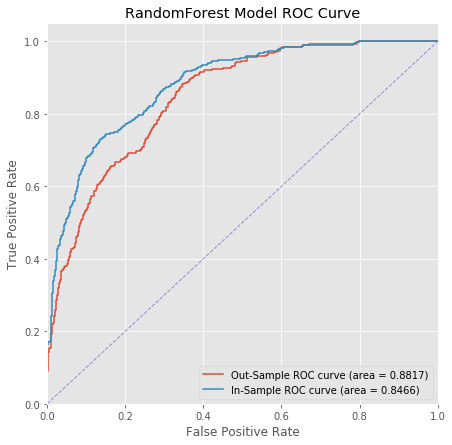

In [36]:
plt.figure(figsize=(7, 7))
plt.plot(out_sample_fpr, out_sample_tpr, label='Out-Sample ROC curve (area = %0.4f)' % in_sample_roc_auc)
plt.plot(in_sample_fpr, in_sample_tpr, label='In-Sample ROC curve (area = %0.4f)' % out_sample_roc_auc)
plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForest Model ROC Curve')
plt.legend(loc="lower right")
plt.show()